In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# from collections.abc import Sequence
from typing import Sequence
import torch
import numpy as np
import time

_SSM_NAME = "JackFram/llama-160m"
_LLM_NAME = 'openlm-research/open_llama_3b_v2'
device = "cuda"

assert torch.cuda.is_available()
tokenizer = AutoTokenizer.from_pretrained(_SSM_NAME)
ssm = AutoModelForCausalLM.from_pretrained(_SSM_NAME).cuda()
llm = AutoModelForCausalLM.from_pretrained(_LLM_NAME).cuda().eval()

/nlp/scr/ananthag/miniconda3/envs/spec/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def _create_token_tree(
    expansion_config: Sequence[int],
    prompt: str,
    tokenizer: AutoTokenizer,
    model: AutoModelForCausalLM,
    has_kv_cache: bool = False,
):
    """Create token tree following Figure 3 in the paper.

    We don't need "real" tokens for our experiments - just
    random integers would work too - but might as well.

    Figure 3 illustrates the <k1, k2, ...> expansion approach they
    use to create token trees. We can use each of the top_k tokens from
    a single model to create the same tree structure.

    Args:
        expansion_config: A sequence of integers representing how much to
            branch at each generation step.
        prompt: Initial prompt.
        tokenizer: HF tokenizer.
        model: HF generative model.
        has_kv_cache: If there are preceding tokens this is generating after, in which
            case we exclude the begin-of-sequence token.
    """
    assert expansion_config
    current_tree = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    if has_kv_cache:
        assert tokenizer.add_bos_token
        current_tree = current_tree[:, 1:]
    for k in expansion_config:
        output = model.generate(
            current_tree,
            max_new_tokens=1,
            return_dict_in_generate=True,
            output_scores=True,
        )
        # Take the top_k tokens from the 1 generation step we've done
        top_k = torch.topk(output.scores[-1], k=k, dim=-1).indices.reshape(-1, 1)
        current_tree = torch.repeat_interleave(current_tree, k, dim=0)
        # Join the top_k tokens to the current tree
        current_tree = torch.cat((current_tree, top_k), dim=-1)

    return current_tree

In [3]:
import torch

def _invert_4d_attention_mask(attention_mask: torch.Tensor, kv_cache_num_tokens: int=0) -> torch.Tensor:
    """For 4D masks, new HF requires us to invert the mask so it doesn't modify it at all."""
    # The attention mask must have last 2 dims shape [current seq len, KV cache size + current seq len]
    # So we prepend a tensor of 1s to allow attending to the full KV cache
    assert attention_mask.dim() == 4
    if kv_cache_num_tokens > 0:
        attention_mask = torch.cat(
            (
                torch.ones(
                    attention_mask.shape[0],
                    attention_mask.shape[1],
                    attention_mask.shape[2],
                    kv_cache_num_tokens,
                ).to(device),
                attention_mask,
            ),
            dim=-1,
        )
    # Invert the mask: 0s to -inf and 1s to 0 (0 means attention allowed)
    min_dtype = torch.finfo(torch.float32).min
    attention_mask.masked_fill_(attention_mask == 0, min_dtype)
    attention_mask.masked_fill_(attention_mask == 1, 0.0)
    return attention_mask

def construct_tree_model_inputs(sequences):
    # input_1 = torch.unique(torch.flatten(sequences), sorted=False)
    flat = torch.flatten(sequences).tolist()
    unique = []
    for tok in flat:
        if tok not in unique:
            unique.append(tok)
    # input is list of unique tokens
    input_1 = torch.tensor([unique]).to(device)

    a = input_1.shape[-1]
    mask_1 = np.zeros((a, a), dtype=np.float32)
    positions = [-1] * len(unique)
    
    for seq in sequences:
        branch_progress = []
        for (pos, tok) in enumerate(seq):
            input_1_idx = unique.index(tok)
            positions[input_1_idx] = pos
            branch_progress.append(input_1_idx)
            for idx in branch_progress:
                mask_1[input_1_idx][idx] = 1
    mask_1 = torch.tensor(mask_1, device=device)
    mask_1 = mask_1.unsqueeze(0).unsqueeze(0).to(device)
    position_ids_1 = torch.tensor([positions], device=device, dtype=torch.int64)
    return (input_1, mask_1, position_ids_1)

In [4]:
def _create_dummy_kv_cache(
    kv_cache_num_tokens: int,
    batch_size: int,
    num_attention_heads: int,
    hidden_size: int,
    num_layers: int,
):
    k = torch.rand(
        batch_size,
        num_attention_heads,
        kv_cache_num_tokens,
        hidden_size // num_attention_heads,
    ).to(device)
    v = torch.rand(
        batch_size,
        num_attention_heads,
        kv_cache_num_tokens,
        hidden_size // num_attention_heads,
    ).to(device)
    return tuple((k, v) for _ in range(num_layers))

In [6]:
llm = AutoModelForCausalLM.from_pretrained(_LLM_NAME,
                                        #    torch_dtype=torch.float16,
                                          #  attn_implementation="sdpa"
                                           ).cuda()

KeyboardInterrupt: 

In [5]:
def time_normal(input_ids, model: AutoModelForCausalLM, kv_cache=None):
    with torch.backends.cuda.sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True, enable_cudnn=False):
        with torch.autocast(device_type='cuda', dtype=torch.float16), torch.inference_mode():
            model(input_ids=input_ids, past_key_values=kv_cache, use_cache=kv_cache is not None)

def time_tree(input_ids, mask, position_ids, model: AutoModelForCausalLM, kv_cache=None):
    with torch.backends.cuda.sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True, enable_cudnn=False):
        with torch.autocast(device_type='cuda', dtype=torch.float16), torch.inference_mode():
            model(input_ids=input_ids, attention_mask=mask, position_ids=position_ids, past_key_values=kv_cache, use_cache=kv_cache is not None)

In [6]:
from torch.profiler import profile, ProfilerActivity, schedule

# Guide: https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html

_N_ITERATIONS = 10
_WAIT_STEPS = 1
_WARMUP_STEPS = 1
schedule_params = {
    'wait': _WAIT_STEPS,
    'warmup': _WARMUP_STEPS,
    'active': _N_ITERATIONS - _WAIT_STEPS - _WARMUP_STEPS,
}
profiler_kwargs = {
    'activities': [ProfilerActivity.CPU, ProfilerActivity.CUDA],
    'profile_memory': True,
    'schedule': schedule(**schedule_params),
    'record_shapes': True,
    'with_stack': True,
    'on_trace_ready': torch.profiler.tensorboard_trace_handler('./log'),
}



def print_normal_profile_stats(input, model):
    with torch.backends.cuda.sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True, enable_cudnn=False):
    with torch.inference_mode(), profile(**profiler_kwargs) as prof:
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            for _ in range(_N_ITERATIONS):
                model(input_ids=input)
                prof.step()
    # print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

def print_tree_profile_stats(input, mask, position_ids, model):
    # with torch.backends.cuda.sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True, enable_cudnn=False):
    with torch.inference_mode(), profile(**profiler_kwargs) as prof:
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            for _ in range(_N_ITERATIONS):
                model(input_ids=input, attention_mask=mask, position_ids=position_ids)
                prof.step()
    # print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [11]:
expansion_config = (7, 1, 1, 1, 1, 1, 1, 1, 1)

# del llm
# llm = AutoModelForCausalLM.from_pretrained(_LLM_NAME).cuda().eval()
token_tree = _create_token_tree(
        expansion_config=expansion_config,
        prompt="The",
        tokenizer=tokenizer,
        model=ssm,
)

print_normal_profile_stats(token_tree, llm)

# tree_input, tree_mask, tree_position_ids = construct_tree_model_inputs(token_tree)
# tree_mask = _invert_4d_attention_mask(tree_mask)
# print_tree_profile_stats(tree_input, tree_mask, tree_position_ids, llm)

past key values None
past key values None
past key values None
past key values None
past key values None
past key values None
past key values None
past key values None
past key values None
past key values None
past key values None
past key values None


STAGE:2024-06-02 18:52:35 905165:905165 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


past key values None
past key values None
past key values None
past key values None
past key values None
past key values None
past key values None


STAGE:2024-06-02 18:52:35 905165:905165 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-06-02 18:52:35 905165:905165 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [10]:
print(token_tree.shape)
# tree_input.shape

torch.Size([7, 11])


In [69]:
# Optionally use the context manager to ensure one of the fused kernels is run
import torch.nn.functional as F
query = torch.rand(32, 8, 128, 64, dtype=torch.float16, device="cuda")
key = torch.rand(32, 8, 128, 64, dtype=torch.float16, device="cuda")
value = torch.rand(32, 8, 128, 64, dtype=torch.float16, device="cuda")
mask = torch.rand(32, 1, 128, 128, dtype=torch.float16, device="cuda")
with torch.backends.cuda.sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True, enable_cudnn=False):
    F.scaled_dot_product_attention(query,key,value, mask)

/nlp/scr/ananthag/miniconda3/envs/spec/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


In [24]:
from transformers import utils

utils.is_flash_attn_2_available()

True

In [64]:
import torch


params = torch.backends.cuda.SDPAParams(
    torch.ones(1, 1, 3, 3, dtype=torch.float16).cuda(),
    torch.ones(1, 1, 3, 3, dtype=torch.float16).cuda(),
    torch.ones(1, 1, 3, 3, dtype=torch.float16).cuda(),
    # None,
    torch.ones(1, 1, 3, 3, dtype=torch.float16).cuda(),
    0.0,
    False
)

torch.backends.cuda.can_use_efficient_attention(params, debug=True)

True

In [ ]:
# Measure max memory allocated
import gc

def reset_memory():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.synchronize()

def end_memory_collection():
    torch.cuda.synchronize()
    max_mem_gb = torch.cuda.max_memory_allocated() / 1024**3
    return max_mem_gb

token_tree = _create_token_tree([2, 2, 2], "The", tokenizer, ssm)
reset_memory()
time_normal(token_tree, llm, kv_cache=None)
seq_max_mem_gb = end_memory_collection()

tree_input, tree_mask, tree_position_ids = construct_tree_model_inputs(token_tree)
tree_mask = _invert_4d_attention_mask(tree_mask)
reset_memory()
time_tree(input_ids=tree_input, mask=tree_mask, position_ids=tree_position_ids, model=llm, kv_cache=None)
tree_max_mem_gb = end_memory_collection()

print(f"Normal: {seq_max_mem_gb:.2f} GB")
print(f"Tree: {tree_max_mem_gb:.2f} GB")

In [11]:
import torch.utils.benchmark as benchmark
import numpy as np

N_ITERATIONS = 32

tree_widths = [4] #range(1, 4)
sequential_times = []
tree_times = []

kv_cache_num_tokens = 128

for tree_width in tree_widths:
    expansion_config = (16, 1, 1, 1, 1, 1)

    token_tree = _create_token_tree(
        expansion_config=expansion_config,
        prompt="The",
        tokenizer=tokenizer,
        model=ssm,
    )
    print(token_tree)

    batch_size=np.prod(expansion_config)
    # kv_cache_sequential = _create_dummy_kv_cache(
    #     kv_cache_num_tokens=kv_cache_num_tokens,
    #     batch_size=batch_size,
    #     num_attention_heads=llm.config.num_attention_heads,
    #     hidden_size=llm.config.hidden_size,
    #     num_layers=llm.config.num_hidden_layers
    # )
    
    sequential_timer = benchmark.Timer(
        stmt="time_normal(input_ids, model, kv_cache)",
        setup="from __main__ import time_normal",
        num_threads=torch.get_num_threads(),
        globals={
            'input_ids': token_tree,
            'model': llm,
            'kv_cache': None
        },
        label="Sequential"
    )
    sequential_measurement = sequential_timer.timeit(N_ITERATIONS)
    sequential_times.append(sequential_measurement.times[-1])
    
    # construct inputs for tree decoding
    # kv_cache_tree = _create_dummy_kv_cache(
    #     kv_cache_num_tokens=kv_cache_num_tokens,
    #     batch_size=1,
    #     num_attention_heads=llm.config.num_attention_heads,
    #     hidden_size=llm.config.hidden_size,
    #     num_layers=llm.config.num_hidden_layers
    # )
    tree_input, tree_mask, tree_position_ids = construct_tree_model_inputs(token_tree)
    print(tree_input, tree_mask, tree_position_ids)
    # Required for 4D mask support in new HF
    tree_mask = _invert_4d_attention_mask(tree_mask, kv_cache_num_tokens)

    tree_timer = benchmark.Timer(
        stmt="time_tree(input_ids, mask, position_ids, model, kv_cache)",
        setup="from __main__ import time_tree",
        num_threads=torch.get_num_threads(),
        globals={
            'input_ids': tree_input,
            'mask': tree_mask,
            'position_ids': tree_position_ids,
            'model': llm,
            'kv_cache': None
        },
        label="Tree"
    )
    tree_measurement = tree_timer.timeit(N_ITERATIONS)
    tree_times.append(tree_measurement.times[-1])
    
    # print_normal_profile_stats(token_tree, llm)
    # print_tree_profile_stats(tree_input, tree_mask, tree_position_ids, llm)

past key values None
past key values None
past key values None
past key values None
past key values None
past key values None
tensor([[    1,   450, 29871, 29896, 29900, 29900, 29995, 20118],
        [    1,   450,   937,  2655,   366,   881,   437,   338],
        [    1,   450,  1900,   982,   304,   679,  4687,   338],
        [    1,   450,  1353,   310,  2305,  1058,   505,  1063],
        [    1,   450,  1556,  4100,  2655,   338,   304,   367],
        [    1,   450,   315, 14044,   261, 29892,   315, 14044],
        [    1,   450,   349,   682,   383, 18966, 30010, 29879],
        [    1,   450,   716,   342,  6124,   304,   278,  3942],
        [    1,   450,  1833,   931,   306,   471,   297,   278],
        [    1,   450,   350, 25365, 29871, 29941, 10488, 29892],
        [    1,   450,   402, 26265,   310,  2259, 29889,    13],
        [    1,   450,  1021,   931, 29892,   278,  5001,   756],
        [    1,   450,  5001,   338,   263,  8236, 13113,   310],
        [    1, 

/nlp/scr/ananthag/miniconda3/envs/spec/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


tensor([[    1,   450, 29871, 29896, 29900, 29995, 20118,   937,  2655,   366,
           881,   437,   338,  1900,   982,   304,   679,  4687,  1353,   310,
          2305,  1058,   505,  1063,  1556,  4100,   367,   315, 14044,   261,
         29892,   349,   682,   383, 18966, 30010, 29879,   716,   342,  6124,
           278,  3942,  1833,   931,   306,   471,   297,   350, 25365, 29941,
         10488,   402, 26265,  2259, 29889,    13,  1021,  5001,   756,   263,
          8236, 13113,  2446,  2462,  3512,   390,   895,   916]],
       device='cuda:0') tensor([[[[1., 0., 0.,  ..., 0., 0., 0.],
          [1., 1., 0.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 1., 1., 0.],
          ...,
          [1., 1., 0.,  ..., 1., 0., 0.],
          [1., 1., 0.,  ..., 1., 1., 0.],
          [1., 1., 0.,  ..., 0., 0., 1.]]]], device='cuda:0') tensor([[0, 1, 6, 7, 5, 6, 7, 2, 4, 4, 5, 6, 3, 2, 3, 7, 5, 6, 2, 4, 4, 5, 6, 7,
         2, 3, 7, 6, 7, 4, 4, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 7, 2, 3

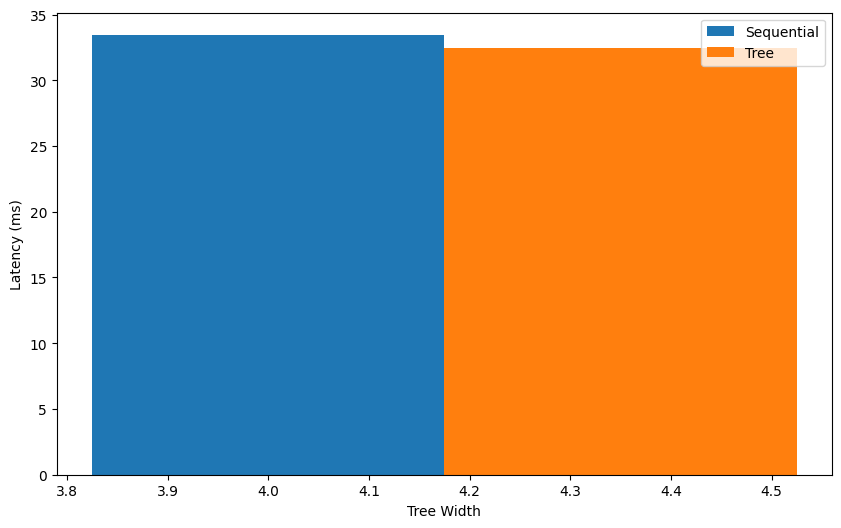

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
import numpy as np

width = 0.35
plt.figure(figsize=(10, 6))

x_data = tree_widths
y_sequential = np.array(sequential_times) * 1000 # scale to ms
plt.bar(x_data, y_sequential, label="Sequential", width=width)  # Plot the first list as the y-axis values
y_tree = np.array(tree_times) * 1000 # scale to ms
plt.bar([pos + width for pos in x_data], y_tree, label="Tree", width=width)  # Plot the second list as the y-axis values

plt.xlabel("Tree Width")
plt.ylabel("Latency (ms)")
plt.legend()

plt.show()
plt.savefig("tree_vs_sequential.png")

In [10]:
import metrics
from transformers import AutoConfig

mistral_7b_config = AutoConfig.from_pretrained("mistralai/Mistral-7B-v0.1")

metrics.identify_compute_memory_bound(
    gpu=metrics.T4,
    token_batch=torch.ones(1, np.sum(np.cumprod(expansion_config))),
    dtype=torch.float32,
    num_layers=mistral_7b_config.num_hidden_layers,
    d_model=mistral_7b_config.hidden_size,
    n_head=mistral_7b_config.num_attention_heads,
    vocab_size=mistral_7b_config.vocab_size,
    kv_cache_token_count=0
)

Memory-bound: arithmetic intensity 7.448872654272583 < 27.0


/nlp/scr/ananthag/miniconda3/envs/spec/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
